In [1]:
from itertools import combinations

import numpy as np
import pandas as pd
import xarray as xr
from plotnine import (
    aes,
    element_blank,
    element_text,
    facet_wrap,
    geom_text,
    geom_tile,
    ggplot,
    labs,
    scale_fill_manual,
    scale_x_discrete,
    scale_y_discrete,
    theme,
    theme_bw,
)
from scores.stats import statistical_tests

from config import MAIN_MODELS, MODEL_ORDER, ROOT
from src.load_data import filter_by_level, load_predictions
from src.scoring_functions import score

In [2]:
def compute_wis_raw(df):
    # Filter rows where 'quantile' is 0.5, rename 'value' to 'med', and drop unnecessary columns
    df_median = df[df["quantile"] == 0.5].copy()
    df_median = df_median.rename(columns={"value": "med"}).drop(
        columns=["quantile", "pathogen", "retrospective", "truth"], errors="ignore"
    )

    # Filter rows where 'type' is 'quantile' and merge with df_median
    df_quantile = df[df["type"] == "quantile"].copy()
    df = df_quantile.merge(df_median, how="left")

    # Compute scores and other metrics row-wise
    df["wis"] = df.apply(
        lambda row: score(row["value"], row["truth"], row["type"], row["quantile"]),
        axis=1,
    )
    df["spread"] = df.apply(
        lambda row: score(row["value"], row["med"], row["type"], row["quantile"]),
        axis=1,
    )
    df["overprediction"] = df.apply(
        lambda row: row["wis"] - row["spread"] if row["med"] > row["truth"] else 0,
        axis=1,
    )
    df["underprediction"] = df.apply(
        lambda row: row["wis"] - row["spread"] if row["med"] < row["truth"] else 0,
        axis=1,
    )

    return df

In [3]:
def variant_label(name: str) -> str:
    variant = name.partition("-")[2]
    return variant if variant else "Coupling"

In [4]:
def plot_diebold_mariano(models, variants=False):
    df = load_predictions()
    df = df[df.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in models]
    df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)

    df_national = filter_by_level(df, "national")
    df_wis = compute_wis_raw(df_national)
    df = (
        df_wis.groupby(["location", "age_group", "model", "date", "horizon"], observed=True)["wis"].mean().reset_index()
    )

    df.date = pd.to_datetime(df.date)

    # keep all horizons > 0
    df = df[df.horizon > 0].copy()

    # per-model maximum available horizon
    max_h_by_model = df.groupby("model", observed=False)["horizon"].max().to_dict()

    df_results = pd.DataFrame()
    for m1, m2 in combinations(model_order, 2):
        df_pair = df[df.model.isin([m1, m2])]

        # pivot to have columns per model to compute score differences
        wide = (
            df_pair.pivot(
                index=["location", "age_group", "date", "horizon"],
                columns="model",
                values="wis",
            )
            .rename_axis(columns=None)
            .reset_index()
        )

        # difference m1 - m2 (will be NaN where one model lacks that horizon/date)
        wide["score_diff"] = wide[m1] - wide[m2]

        # reshape to timeseries matrix: rows = dates, cols = horizons
        df_temp = (
            wide.pivot(index="date", columns="horizon", values="score_diff")
            .rename_axis(index="valid_date", columns="horizon")
            .sort_index()
        )

        # only keep horizons that BOTH models support
        allowed_horizons = [
            int(h)
            for h in df_temp.columns
            if int(h) <= max_h_by_model.get(m1, -np.inf) and int(h) <= max_h_by_model.get(m2, -np.inf)
        ]
        if not allowed_horizons:
            continue

        df_temp = df_temp[allowed_horizons]

        # drop dates where any of the kept horizons is missing
        df_temp = df_temp.dropna()
        if df_temp.empty:
            continue

        da = xr.DataArray(
            data=df_temp.T.to_numpy(),
            dims=["horizon", "valid_date"],
            coords={
                "horizon": list(map(int, df_temp.columns)),
                "valid_date": ("valid_date", pd.to_datetime(df_temp.index)),
                "h": ("horizon", list(map(int, df_temp.columns))),
            },
            name="score_diff",
        )

        results = statistical_tests.diebold_mariano(da, ts_dim="horizon", h_coord="h")
        results = results[["horizon", "confidence_gt_0"]].to_pandas().reset_index()
        results["m1"] = m1
        results["m2"] = m2
        df_results = pd.concat([df_results, results], ignore_index=True)

    df_results = df_results.rename(columns={"confidence_gt_0": "pval"})
    df_results["pval_two_sided"] = 2 * np.minimum(df_results["pval"], 1 - df_results["pval"])

    d1 = df_results.copy()
    d1["m1"] = pd.Categorical(d1["m1"], categories=model_order, ordered=True)
    d1["m2"] = pd.Categorical(d1["m2"], categories=model_order[::-1], ordered=True)
    d1["sig"] = d1["pval_two_sided"] < 0.05

    xkw = {"limits": model_order, "drop": False}
    ykw = {"limits": model_order, "drop": False}
    if variants:
        xkw["labels"] = lambda xs: [variant_label(x) for x in xs]
        ykw["labels"] = lambda ys: [variant_label(y) for y in ys]

    p = (
        ggplot(d1, aes("m2", "m1"))
        + facet_wrap("horizon", ncol=2, labeller=lambda x: "Horizon: " + str(x))
        + geom_tile(aes(fill="sig"), width=0.95, height=0.95, alpha=0.4, show_legend=False)
        + geom_text(aes(label="pval_two_sided"), format_string="{:.3f}", size=7)
        + scale_fill_manual(values={True: "#228B22", False: "gray"}, na_value="white")
        + scale_x_discrete(**xkw)
        + scale_y_discrete(**ykw)
        + theme_bw()
        + theme(
            panel_grid=element_blank(),
            plot_title=element_text(size=11),
            strip_text=element_text(size=9),
            legend_title=element_text(size=9),
            legend_text=element_text(size=8),
            axis_title=element_text(size=10),
            axis_text_x=element_text(size=8, rotation=90, ha="center", ma="right"),
            axis_text_y=element_text(size=8),
        )
        + labs(x="", y="", title=models[0] if variants else "")
    )

    return p


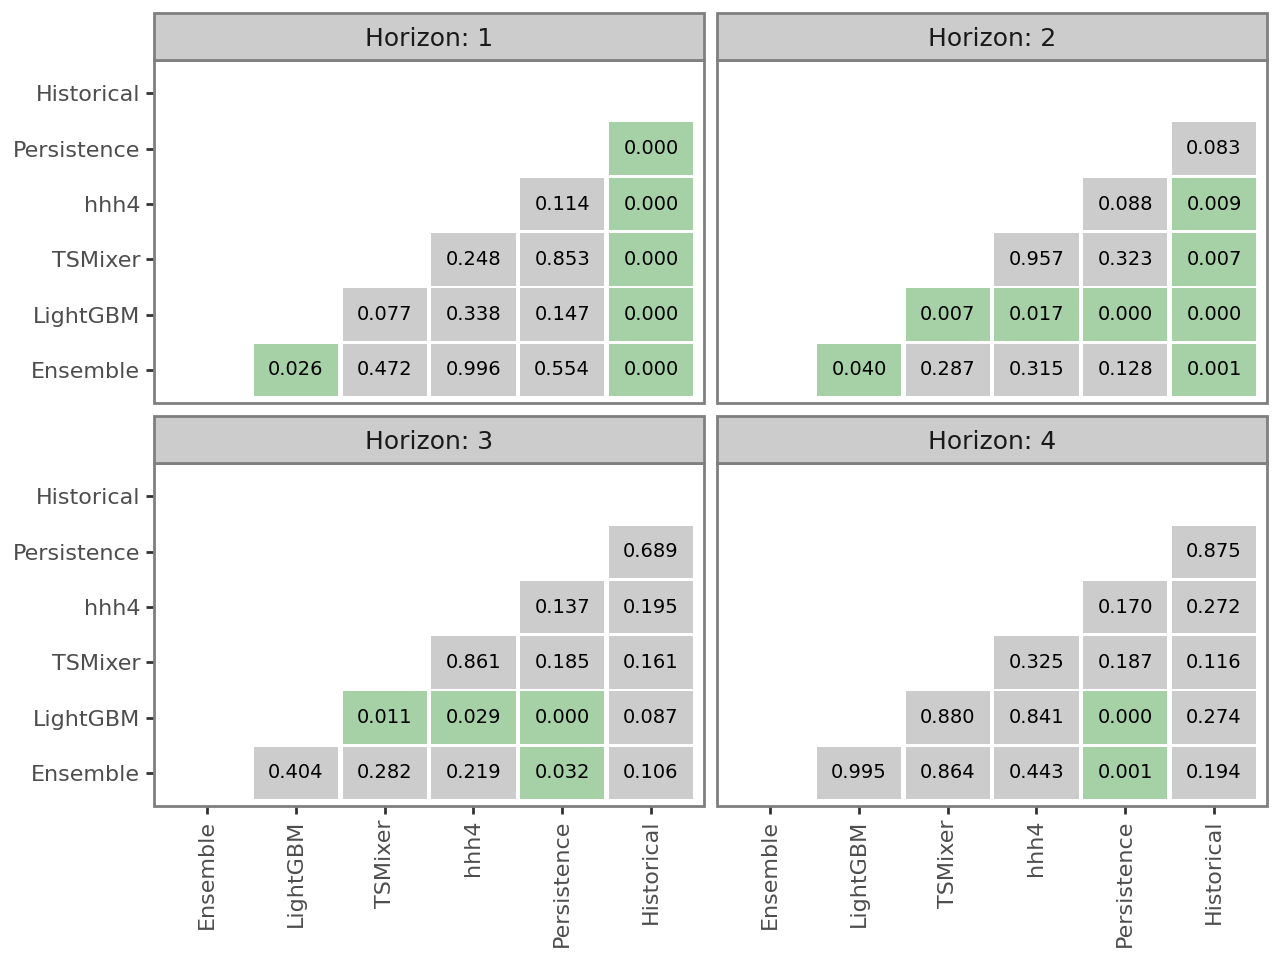

In [5]:
p = plot_diebold_mariano(MAIN_MODELS, False)
p.show()

In [6]:
p.save(ROOT / "figures" / "dm_test.pdf", width=160, height=140, units="mm", dpi=600, verbose=False)

In [7]:
hhh4_variants = ["hhh4", "hhh4-Oracle", "hhh4-Discard", "hhh4-Naive"]

lightgbm_variants = [
    "LightGBM",
    "LightGBM-Oracle",
    "LightGBM-Discard",
    "LightGBM-Naive",
]

tsmixer_variants = [
    "TSMixer",
    "TSMixer-Oracle",
    "TSMixer-Discard",
    "TSMixer-Naive",
]

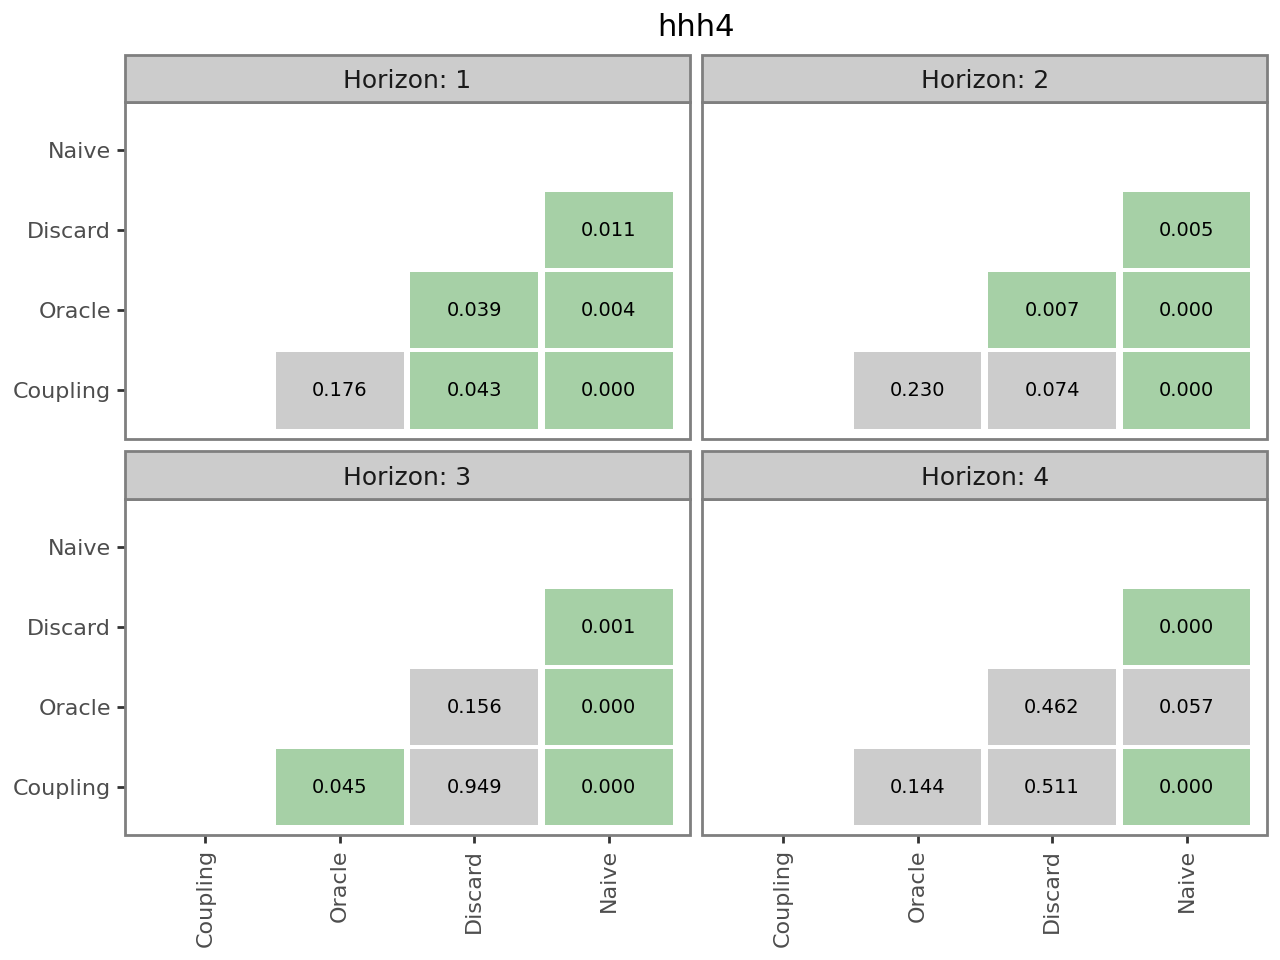

In [8]:
p = plot_diebold_mariano(hhh4_variants, True)
p.show()

In [9]:
p.save(
    ROOT / "figures" / "dm_test_hhh4.pdf",
    width=95,
    height=80,
    units="mm",
    dpi=600,
    verbose=False,
)

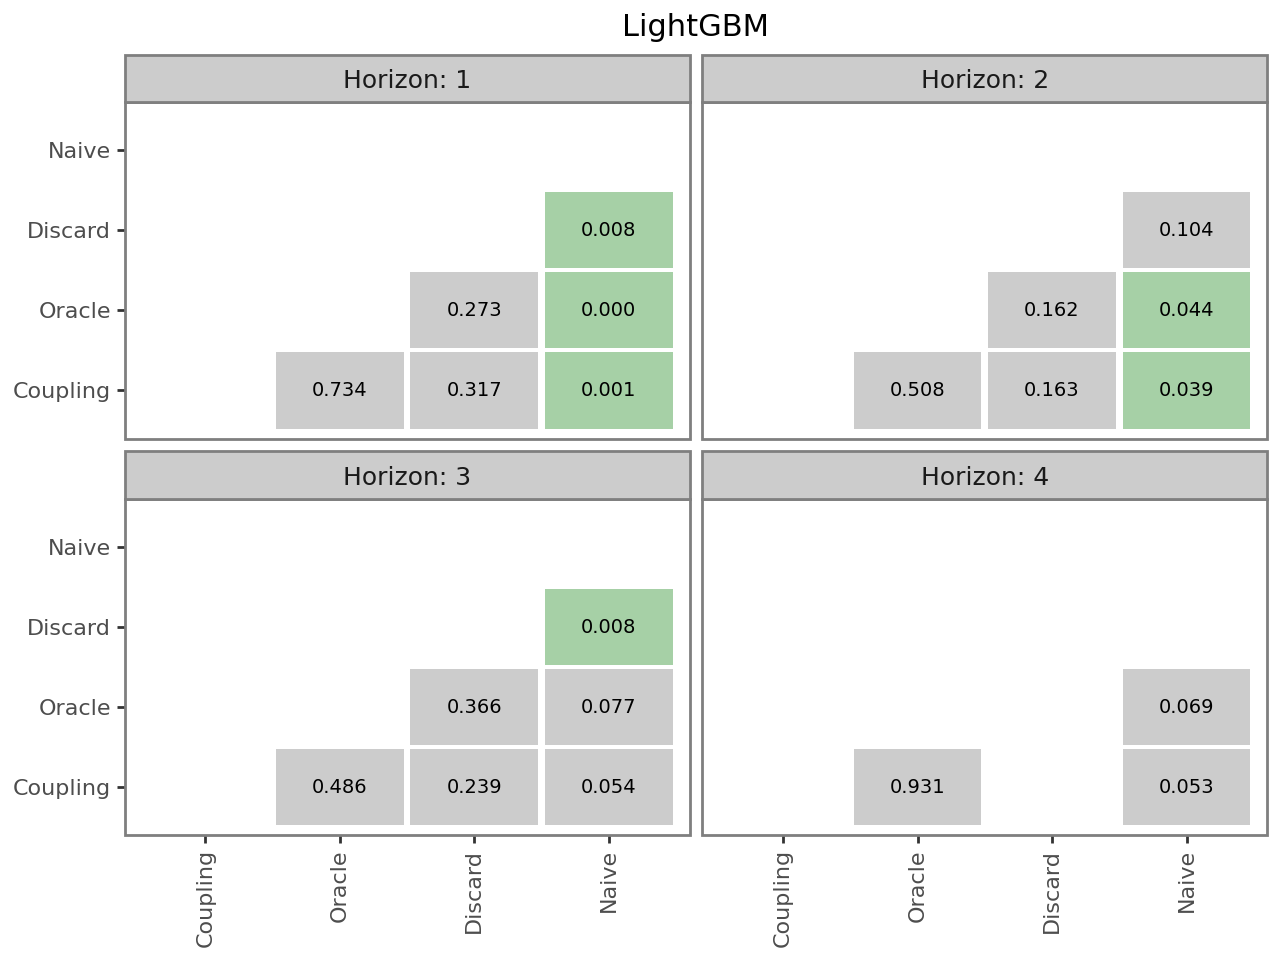

In [10]:
p = plot_diebold_mariano(lightgbm_variants, True)
p.show()

In [11]:
p.save(
    ROOT / "figures" / "dm_test_lightgbm.pdf",
    width=95,
    height=80,
    units="mm",
    dpi=600,
    verbose=False,
)

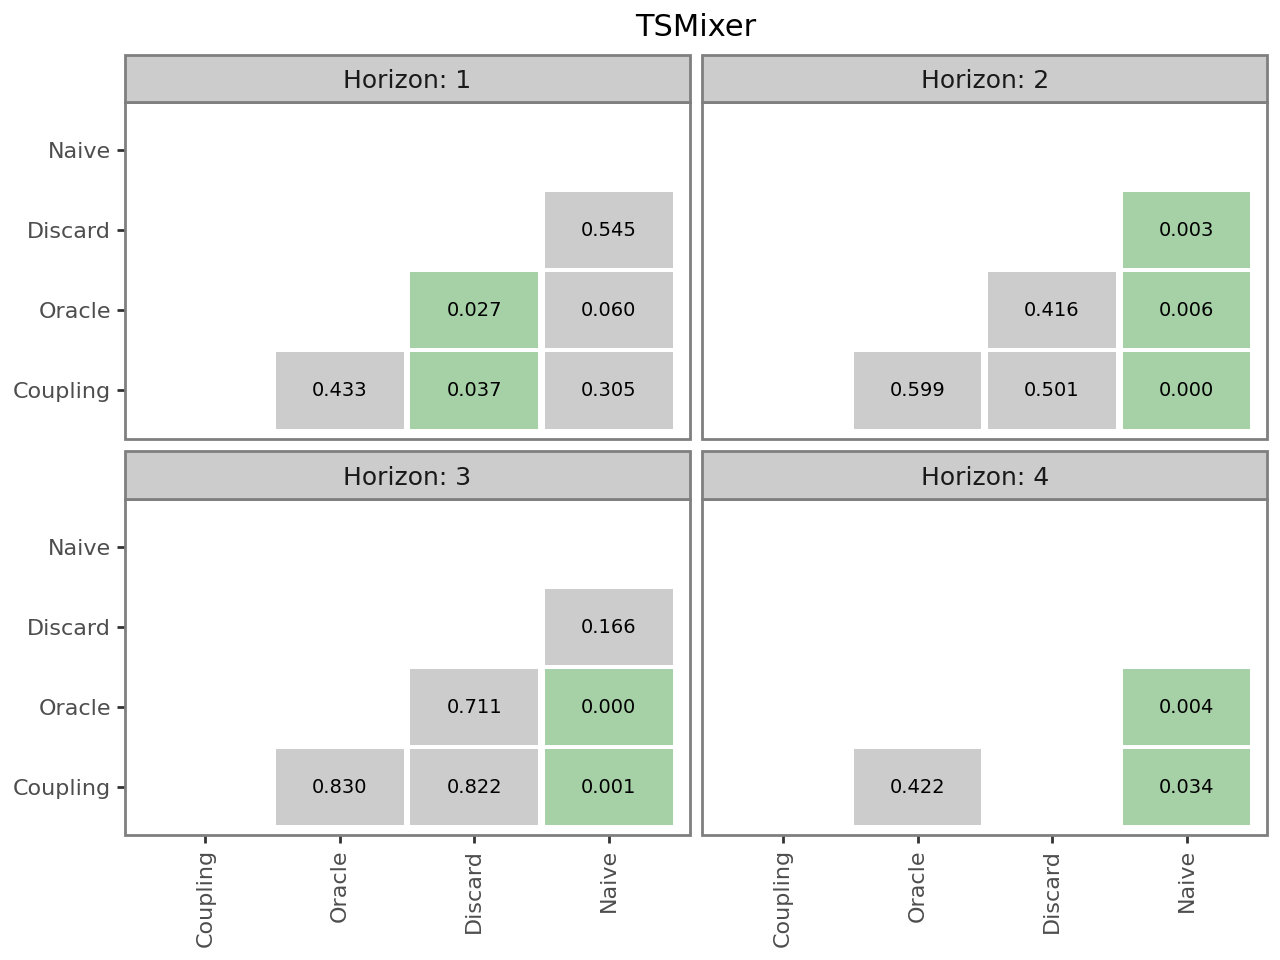

In [12]:
p = plot_diebold_mariano(tsmixer_variants, True)
p.show()

In [13]:
p.save(
    ROOT / "figures" / "dm_test_tsmixer.pdf",
    width=95,
    height=80,
    units="mm",
    dpi=600,
    verbose=False,
)